In [2]:
from langchain.schema import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import Chroma

gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

docs_travel = [
    Document(
        page_content="Travories is a travel booking platform where travel agencies can create and list their tour packages. Tourists can browse and book these packages directly through the platform. Travories aims to connect travelers with a wide variety of curated travel experiences.",
        metadata={"source": "overview.txt"}
    ),
    Document(
        page_content="Travories is accessible 24 hours a day, 7 days a week, allowing both agencies and tourists to use the platform at their convenience, regardless of their time zone.",
        metadata={"source": "availability.txt"}
    ),
    Document(
        page_content="Travel agencies on Travories have the ability to create detailed descriptions of their tour packages, including itineraries, pricing, inclusions, and stunning visuals. They manage their own listings and availability.",
        metadata={"source": "agency_features.txt"}
    ),
    Document(
        page_content="Tourists using Travories can search for travel packages based on destination, interests, duration, and budget. They can view package details, read reviews (if available), and securely book their chosen tours through the platform.",
        metadata={"source": "tourist_features.txt"}
    ),
    Document(
        page_content="For any inquiries or support, users can contact Travories customer support via email at support@travories.com or through the live chat feature available on the website and mobile app.",
        metadata={"source": "support.txt"}
    ),
    Document(
        page_content="Travories supports various payment methods, including major credit cards, debit cards, and popular online payment gateways, ensuring a seamless booking experience for tourists worldwide.",
        metadata={"source": "payment.txt"}
    ),
]

db = Chroma.from_documents(docs_travel, gemini_embeddings)


In [3]:
retriever = db.as_retriever(search_type="similarity", search_kwargs = {"k": 5})

In [4]:
from langchain_core.prompts import ChatPromptTemplate

template = """ 
Answer the question based only on the following context: {context}
Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [5]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

def format_docs(docs): 
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm

In [6]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain.schema import Document

In [7]:
class AgentState(TypedDict):
    messages: list[BaseMessage]
    documents: list[Document]
    on_topic: str

In [9]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class GradeQuestion(BaseModel):
    """ Boolean value to check whether a question is related to the Peak Performance Gym """

    score: str = Field(
        description="Question is about gym? If yes -> 'Yes' if not -> 'No' "
    )

def question_classifier(state: AgentState): 
    question = state["messages"][-1].content
    system = """You are a classifier that determines whether a user's question is about Travories, a travel booking platform. 
    
    The topics include:
    1.  Platform Overview and Purpose
    2.  Platform Availability
    3.  Features for Travel Agencies
    4.  Features for Tourists
    5.  Customer Support
    6.  Payment Methods
    
    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system), 
            ("human", "User question: {question}")
        ]
    )

    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    
    state["on_topic"] = result.score

    return state

In [10]:
def on_topic_router(state: AgentState): 
    on_topic = state["on_topic"]
    if on_topic.lower() == "yes":
        return "on_topic"
    return "off_topic"


def retrieve(state: AgentState):
    question = state["messages"][-1].content
    documents = retriever.invoke(question)
    state["documents"] = documents
    return state


def generate_answer(state: AgentState): 
    question = state["messages"][-1].content
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question": question})
    state["messages"].append(generation)

def off_topic_response(state: AgentState): 
    state["messages"].append(AIMessage(content="I'm sorry! I cannot answer this question!"))
    return state


In [11]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate_answer", generate_answer)

workflow.add_conditional_edges(
    "topic_decision", 
    on_topic_router, 
    {
        "on_topic": "retrieve", 
        "off_topic": "off_topic_response"
    }
)

workflow.add_edge("retrieve", "generate_answer")
workflow.add_edge("generate_answer", END)
workflow.add_edge("off_topic_response", END)

workflow.set_entry_point("topic_decision")
graph = workflow.compile()

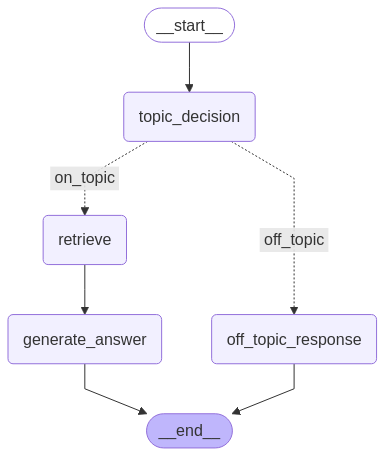

In [12]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [14]:
graph.invoke(input={"messages": [HumanMessage(content="What is Travories?")]})

{'messages': [HumanMessage(content='What is Travories?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Based on the provided text, Travories is a travel booking platform where travel agencies can create and list their tour packages.  Tourists can browse and book these packages directly through the platform.  Travories aims to connect travelers with a wide variety of curated travel experiences.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--1715b0de-899f-4e18-8fe9-8f8cd75aac37-0', usage_metadata={'input_tokens': 309, 'output_tokens': 55, 'total_tokens': 364, 'input_token_details': {'cache_read': 0}})],
 'documents': [Document(metadata={'source': 'support.txt'}, page_content='For any inquiries or support, users can contact Travories customer support via email at support@travories.com or through the live chat feature available on the website and mobile app

In [16]:
graph.invoke(input={"messages": [HumanMessage(content="How do I book a flight to London?")]})

{'messages': [HumanMessage(content='How do I book a flight to London?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry! I cannot answer this question!", additional_kwargs={}, response_metadata={})],
 'on_topic': 'No'}

In [17]:
graph.invoke(input={"messages": [HumanMessage(content="What payment methods are supported?")]})

{'messages': [HumanMessage(content='What payment methods are supported?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Based on the provided text, Travories supports major credit cards, debit cards, and popular online payment gateways.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--4a87ce7e-61f9-4697-a2b8-0499c9f7c429-0', usage_metadata={'input_tokens': 271, 'output_tokens': 23, 'total_tokens': 294, 'input_token_details': {'cache_read': 0}})],
 'documents': [Document(metadata={'source': 'payment.txt'}, page_content='Travories supports various payment methods, including major credit cards, debit cards, and popular online payment gateways, ensuring a seamless booking experience for tourists worldwide.'),
  Document(metadata={'source': 'payment.txt'}, page_content='Travories supports various payment methods, including major credit cards, debit cards, and 